## Purpose

This notebook demonstrates how to build a natural language interface to a SQL database using LangChain, SQLAlchemy, and OpenAI's language models. The primary goal is to enable users to interact with a relational database by asking questions in plain English and receiving accurate, context-aware responses generated by a language model.

Key Components:

- SQLAlchemy & SQLite: The notebook sets up an in-memory SQLite database using SQLAlchemy, defines tables (such as employees and projects), and populates them with sample data.
- LangChain & OpenAI: By integrating LangChain's SQLDatabaseChain and OpenAI's language models, the notebook enables natural language queries to be translated into SQL, executed, and the results returned in user-friendly language.
- Agent & State Management: The workflow includes an agent architecture for classifying questions (semantic, structured, or hybrid), generating SQL queries, and managing conversational state.
- Demonstrations: Example queries showcase how to retrieve insights from the database, such as average salaries or project details, using conversational input.

In [ ]:
# pip install sqlalchemy
# pip install langchain
# pip install langchain-experimental
# pip install langchain-openai
# pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [203]:
from langchain_experimental.sql import SQLDatabaseChain
from langchain_openai import ChatOpenAI
from langchain.sql_database import SQLDatabase
from sqlalchemy import create_engine

from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv
import os

### DataBase Connection, Creation and Insertion of Data

In [204]:
# Setup SQLAlchemy engine for in-memory SQLite
engine = create_engine("sqlite:///:memory:")

# Now use engine to create tables and insert data
with engine.connect() as conn:
    conn.execute(
        """
        CREATE TABLE employees (
            id INTEGER PRIMARY KEY,
            name TEXT,
            department TEXT,
            salary REAL,
            hire_date DATE
        )
        """
    )
    conn.execute(
        """
        CREATE TABLE projects (
            id INTEGER PRIMARY KEY,
            project_name TEXT,
            budget REAL,
            status TEXT,
            start_date DATE
        )
        """
    )
    conn.execute(
        "INSERT INTO employees VALUES (1, 'John Doe', 'Engineering', 75000, '2022-01-15')"
    )
    conn.execute(
        "INSERT INTO employees VALUES (2, 'Jane Smith', 'Marketing', 65000, '2021-03-20')"
    )
    conn.execute(
        "INSERT INTO employees VALUES (3, 'Bob Johnson', 'Engineering', 80000, '2020-06-10')"
    )
    conn.execute(
        "INSERT INTO employees VALUES (4, 'Alice Brown', 'HR', 60000, '2023-02-28')"
    )
    conn.execute(
        "INSERT INTO projects VALUES (1, 'Website Redesign', 50000, 'Active', '2024-01-01')"
    )
    conn.execute(
        "INSERT INTO projects VALUES (2, 'Mobile App', 100000, 'Completed', '2023-06-15')"
    )
    conn.execute(
        "INSERT INTO projects VALUES (3, 'AI Integration', 150000, 'Planning', '2024-03-01')"
    )

### SQL database chain

In [205]:
# Wrap the engine with SQLDatabase
db = SQLDatabase(engine)

In [206]:
# Initialize LLM
llm = ChatOpenAI(model="gpt-4", temperature=0)

In [207]:
# Setup SQLDatabaseChain
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)

In [198]:
# Example: Ask a question
result = db_chain.run("What is the average salary in the Engineering department?")
print(result)



> Entering new SQLDatabaseChain chain...
What is the average salary in the Engineering department?
SQLQuery:SELECT AVG("salary") FROM employees WHERE "department" = 'Engineering'
SQLResult: [(77500.0,)]
Answer:The average salary in the Engineering department is $77,500.
> Finished chain.
The average salary in the Engineering department is $77,500.


------------

## Agent

In [199]:
# Define the state structure
class AgentState(TypedDict):
    question: str
    question_type: Literal["semantic", "structured", "hybrid"]
    final_answer: str
    messages: list

### Nodes

In [222]:
# Node 1: Question Classification
def classify_question(state: AgentState) -> AgentState:
    """Analyze the question to determine its type"""
    
    classification_prompt = ChatPromptTemplate.from_template(
        """
        Analyze the following question and classify it as one of these types:
        
        1. "semantic" - Questions that require understanding context, meaning, or general knowledge
           Examples: "What is machine learning?", "Explain the concept of...", "How does X work?"
        
        2. "structured" - Questions that can be answered with specific data queries from databases
           Examples: "How many employees are in engineering?", "What's the average salary?", "List all active projects"
        
        3. "hybrid" - Questions that require both structured data retrieval AND semantic understanding
           Examples: "Analyze the salary trends and explain what they mean", "Compare project budgets and suggest improvements"
        
        Question: {question}
        
        Database Schema Information:
        - employees table: id, name, department, salary, hire_date
        - projects table: id, project_name, budget, status, start_date
        
        Respond with ONLY one word: semantic, structured, or hybrid
        """
    )
    
    # compose the chain
    # state["question"] → classification_prompt (formatting) → llm (generation) → response
    chain = classification_prompt | llm  # compose the chain # send to the LLM
     # Run the chain with the user's question 
    response = chain.invoke({"question": state["question"]}) # Run the chain with the user's question
    
    question_type = response.content.strip().lower() # Get the response content and strip any leading/trailing whitespace
    
    # Validate the response - # Fallback for unexpected responses
    if question_type not in ["semantic", "structured", "hybrid"]:
        question_type = "semantic"  # Default fallback
    
    # Update and return the state with classification
    return {
        **state, # Take all the existing keys/values from state, rewrite question_type and messatges
        "question_type": question_type,
        "messages": state.get("messages", []) + [
            HumanMessage(content=f"Question: {state['question']}"),
            AIMessage(content=f"Classification: {question_type}")
        ]
    }

In [223]:
# Node 2: SQL Query Generation and response
def process_sql_query(state: AgentState) -> AgentState:
    """Generate SQL query for structured questions"""
    
    # Create the SQL database chain directly
    db_chain = SQLDatabaseChain.from_llm(
        llm=llm, 
        db=db, 
        verbose=False,
        return_intermediate_steps=False  # Optional: to see intermediate steps
    )
    
    # Invoke the chain with the question
    try:
        response = db_chain.invoke({"query": state["question"]})
        
        # Extract the final answer from the response
        if isinstance(response, dict):
            final_answer = response.get("result", response.get("answer", str(response)))
        else:
            final_answer = str(response)
            
    except Exception as e:
        final_answer = f"Error executing SQL query: {str(e)}"
    
    return {
        **state,
        "final_answer": final_answer,
        "messages": state.get("messages", []) + [
            HumanMessage(content=state["question"]),
            AIMessage(content=final_answer)
        ]
    }

In [224]:
# Node 3: Semantic Processing (for semantic questions)
def process_semantic_question(state: AgentState) -> AgentState:
    """Process semantic questions using general knowledge"""
    
    semantic_prompt = ChatPromptTemplate.from_template(
        """
        Answer the following question using your knowledge and reasoning capabilities.
        Provide a comprehensive and helpful response.

        Question: {question}
        """
    )
    
    chain = semantic_prompt | llm # Create a chain of prompts and LLM
    response = chain.invoke({"question": state["question"]}) # Invoke the chain

    return { # Return updated state including messages
        **state,
        "final_answer": response.content,
        "messages": state.get("messages", []) + [
            AIMessage(content=f"Answer:\n{response.content}")
        ]
    }

### Routing Function

In [212]:
# Routing function
def route_question(state: AgentState):
    """Route the question based on its classification"""
    question_type = state["question_type"]
    
    if question_type == "structured":
        return "process_sql_query"
    elif question_type == "semantic":
        return "process_semantic"
    elif question_type == "hybrid":
        return "process_sql_query"  # Hybrid questions also need structured data first
    else:
        return "process_semantic"  # Default to semantic

### Pipeline Creation

In [225]:
# Build the graph
workflow = StateGraph(AgentState)
    
# Add nodes
workflow.add_node("classify", classify_question)
workflow.add_node("process_sql_query", process_sql_query)
workflow.add_node("process_semantic", process_semantic_question)
    
# Add edges
workflow.set_entry_point("classify")
    
# Conditional routing after classification
workflow.add_conditional_edges(
        "classify",
        route_question,
        {
            "process_sql_query": "process_sql_query",
            "process_semantic": "process_semantic"
        }
    )
    
# Semantic flow goes directly to end
workflow.add_edge("process_semantic", END)
    
# Final answer goes to end
workflow.add_edge("process_sql_query", END)
    
graph = workflow.compile()

#### Graph Diagram

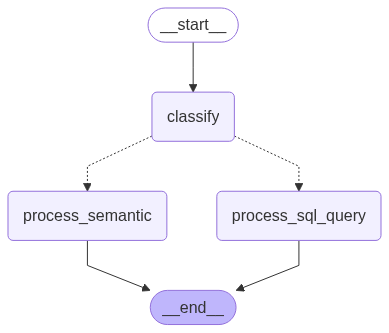

In [226]:
from IPython.display import Image, display
# Create and display the graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [227]:
# Invoke the graph
graph.invoke({"question": "What is the average salary in Engineering?"})

{'question': 'What is the average salary in Engineering?',
 'question_type': 'structured',
 'final_answer': 'The average salary in Engineering is $77,500.',
 'messages': [HumanMessage(content='Question: What is the average salary in Engineering?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Classification: structured', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the average salary in Engineering?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The average salary in Engineering is $77,500.', additional_kwargs={}, response_metadata={})]}

In [228]:
#Or 
state=graph.invoke({"question": "What is the average salary in Engineering?"})
print("\n💡 Final Answer:\n", state["final_answer"])


💡 Final Answer:
 The average salary in Engineering is $77,500.


In [229]:
state = graph.invoke({"question": "I want to know shortly what is machine learning?"})

#Print final answer
print("\n💡 Final Answer:\n", state["final_answer"])


💡 Final Answer:
 Machine learning is a subset of artificial intelligence (AI) that provides systems the ability to automatically learn and improve from experience without being explicitly programmed. It focuses on the development of computer programs that can access data and use it to learn for themselves. The process of learning begins with observations or data, such as examples, direct experience, or instruction, to look for patterns in data and make better decisions in the future based on the examples that we provide. The primary aim is to allow the computers to learn automatically without human intervention or assistance and adjust actions accordingly.


In [219]:
state = graph.invoke({"question": "What is the average salary in the Marketing department, and how many employees are in this department?"})
#Print final answer
print("\n💡 Final Answer:\n", state["final_answer"])


💡 Final Answer:
 The average salary in the Marketing department is $65,000 and there is 1 employee in this department.


In [220]:
state = graph.invoke({"question": "What is the average salary in the Marketing department, and what does a marketing deparment does usually?"})
#Print final answer
print("\n💡 Final Answer:\n", state["final_answer"])


💡 Final Answer:
 The average salary in the Marketing department is 65000.0. As for what a marketing department usually does, it is responsible for promoting the company's products or services, conducting market research, developing marketing strategies, and communicating with target audiences.


We can also set verbose to True to see the intermediate steps. This will allow us to see the query that is being executed and the response from the LLM.

In [221]:
# Setup SQLDatabaseChain
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)

# Or in the node: 
# db_chain = SQLDatabaseChain.from_llm(llm=llm, db=db, verbose=False, return_intermediate_steps=False)

# Example: Ask a question
result = db_chain.run("What is the average salary in the Engineering department?")
print(result)



> Entering new SQLDatabaseChain chain...
What is the average salary in the Engineering department?
SQLQuery:SELECT AVG("salary") FROM employees WHERE "department" = 'Engineering'
SQLResult: [(77500.0,)]
Answer:The average salary in the Engineering department is $77,500.
> Finished chain.
The average salary in the Engineering department is $77,500.
